Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [3]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [5]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [6]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]


Function to generate a training batch for the skip-gram model.

In [7]:
data_index = 0

# 8, 2, 1
# 8, 4, 2
def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window

  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)

  span = 2 * skip_window + 1 # [ skip_window target skip_window ]

  buffer = collections.deque(maxlen=span)
    
  # Moves _span_ number of times, wrap around if > len
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)

  # buffer = anarchism, originated, as

  # 4 times
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    # target 0
    # avoid [0]
    targets_to_avoid = [ skip_window ]
    
    # 2 times
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      # batch[0] = buffer[0]
      # labels[0, 0] = buffer[2]
    
      # batch[1] = buffer[0]
      # labels[1, 0] = buffer[1]
    
      # batch[2] = buffer[0]
      # labels[2, 0] = buffer[2]
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
    
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print(batch.shape)
    print(labels.shape)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']
(8,)
(8, 1)

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['as', 'anarchism', 'originated', 'a', 'as', 'term', 'a', 'of']
(8,)
(8, 1)

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['a', 'anarchism', 'originated', 'term', 'originated', 'of', 'term', 'as']


Train a skip-gram model.

In [8]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))

  softmax_weights = tf.Variable(
        tf.truncated_normal(
            [vocabulary_size, embedding_size], 
            stddev=1.0 / math.sqrt(embedding_size)
        )
    )
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  print(embed)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(
        softmax_weights, softmax_biases, embed, train_labels, num_sampled, vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

Tensor("embedding_lookup:0", shape=(128, 128), dtype=float32, device=/device:CPU:0)


In [27]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    # Build batch data for the model
    batch_data, batch_labels = generate_batch(batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    
    # Feed into model
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    
    average_loss += l
    
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
        
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.238001
Nearest to however: geodesic, moray, epistle, sticker, zuid, cornwell, apc, sprinkled,
Nearest to more: accident, vegetarianism, galveston, brie, syphilis, phocas, homepage, crouch,
Nearest to history: culbert, brewing, gladly, transposition, barbarous, peterborough, marcius, drumlins,
Nearest to eight: vorder, hau, dyson, thoughts, glitch, prank, irreversible, december,
Nearest to only: espa, dans, joyous, fan, esr, marquise, mahesh, jakobson,
Nearest to was: brilliantly, peppard, politics, fires, deviated, apps, sheds, hennepin,
Nearest to no: salim, porgy, jing, examining, apparently, hospitalization, marked, commas,
Nearest to as: interdependence, spontaneity, manors, koenig, glissando, tigre, oahu, phenols,
Nearest to been: capricious, slovenians, whitey, singaporean, convinced, bombardment, mmu, stomachs,
Nearest to four: metastable, ebcdic, pederasty, assistive, blica, subverting, entirely, chuang,
Nearest to three: contagion, afp, pr

In [28]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

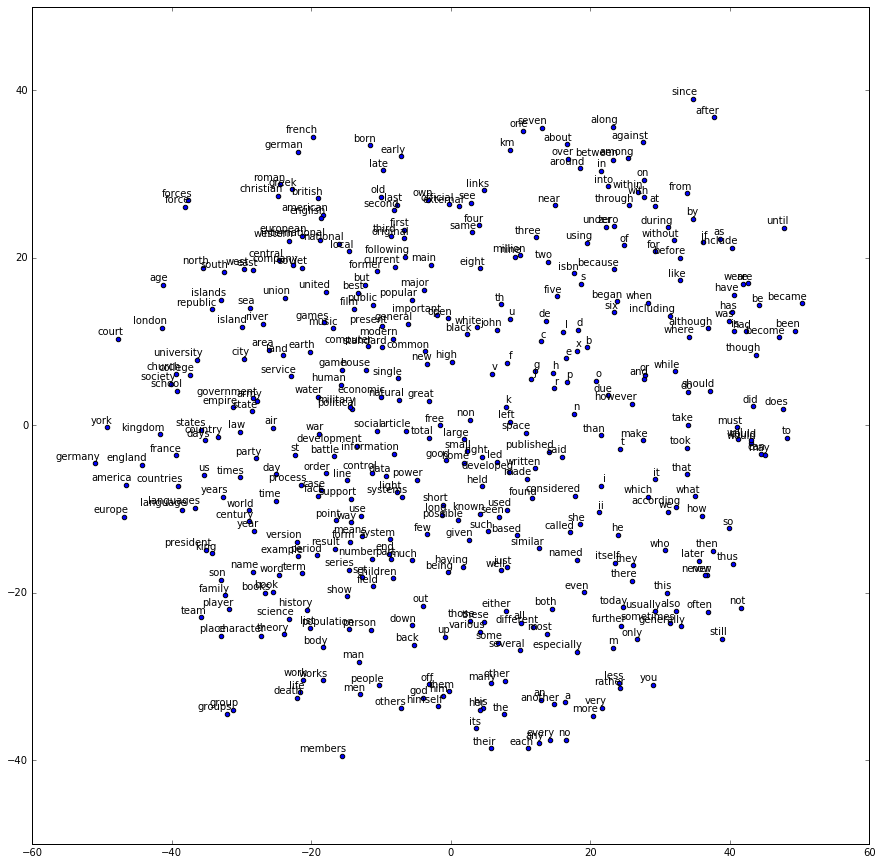

In [29]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

In [61]:
data_index = 0

def generate_batch_cbow(batch_size, skip_window):
  global data_index
  # calculate the context_window - this is the total number of words around the target
  context_window = 2 * skip_window 

  assert batch_size % context_window == 0 # ensure the context window can be taken from the batch size
  num_labels = batch_size / context_window # the number of labels is the how many context windows fit in the batch
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(num_labels, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)

  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
    
  for i in range(num_labels):
    target = skip_window  # target label at the center of the buffer
    labels[i, 0] = buffer[target] # set the label
    targets_to_avoid = [ skip_window ]
    
    for j in range(context_window):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * context_window + j] = buffer[target]
        
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
    
  return batch, labels

skip_window = 1
batch, labels = generate_batch_cbow(8, skip_window)
print(np.shape(labels)) # 4, 1
print(labels)

print(np.shape(batch)) # 8,
print(batch)

# batch is data
# labels is target
for i in range(8):
  print('--------------')
  print(batch[i], '->', labels[i/(2*skip_window), 0])
  print(reverse_dictionary[batch[i]], '->', reverse_dictionary[labels[i/(2*skip_window), 0]])
    
del skip_window # remove skip_window setting used for testing

(4, 1)
[[3084]
 [  12]
 [   6]
 [ 195]]
(8,)
[  12 5239 3084    6   12  195    2    6]
--------------
12 -> 3084
as -> originated
--------------
5239 -> 3084
anarchism -> originated
--------------
3084 -> 12
originated -> as
--------------
6 -> 12
a -> as
--------------
12 -> 6
as -> a
--------------
195 -> 6
term -> a
--------------
2 -> 195
of -> term
--------------
6 -> 195
a -> term


In [63]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(xrange(valid_window), valid_size))
num_sampled = 32 # Number of negative examples to sample.

## General defines
context_window = 2 * skip_window
num_labels = batch_size / context_window

graph = tf.Graph()

with graph.as_default():

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[num_labels, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)

  # seq_ids only needs to be generated once so do this as a numpy array rather than a tensor.
  seq_ids = np.zeros(batch_size, dtype=np.int32)
  cur_id = -1
  for i in range(batch_size):
    if i % context_window == 0:
      cur_id = cur_id + 1
    seq_ids[i] = cur_id
  print(seq_ids)
  
  # use segment_sum to add together the related words and reduce the output to be num_labels in size.
  final_embed = tf.segment_mean(embed, seq_ids)
  
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, final_embed,
                               train_labels, num_sampled, vocabulary_size))

  # Optimizer.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

[ 0  0  1  1  2  2  3  3  4  4  5  5  6  6  7  7  8  8  9  9 10 10 11 11 12
 12 13 13 14 14 15 15 16 16 17 17 18 18 19 19 20 20 21 21 22 22 23 23 24 24
 25 25 26 26 27 27 28 28 29 29 30 30 31 31 32 32 33 33 34 34 35 35 36 36 37
 37 38 38 39 39 40 40 41 41 42 42 43 43 44 44 45 45 46 46 47 47 48 48 49 49
 50 50 51 51 52 52 53 53 54 54 55 55 56 56 57 57 58 58 59 59 60 60 61 61 62
 62 63 63]


In [64]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  average_loss = 0
  for step in xrange(num_steps):
    batch_data, batch_labels = generate_batch_cbow(batch_size, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print("Average loss at step", step, ":", average_loss)
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in xrange(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = "Nearest to %s:" % valid_word
        for k in xrange(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = "%s %s," % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0 : 7.24851512909
Nearest to states: reconsideration, nobi, briggs, japan, macabre, flavour, bred, domineering,
Nearest to about: deutscher, lust, extremism, warlords, nonstandard, purchaser, zuma, wore,
Nearest to use: rivaled, girdle, boa, collapses, kodiak, inevitably, cheyenne, manny,
Nearest to by: sacher, pledges, milton, daugavpils, swinburne, amu, tibeto, bionic,
Nearest to s: replicator, ineffective, dryope, kaye, muir, wallabies, fulfilled, rankings,
Nearest to so: tapping, polonium, lighting, conscription, recycled, aslan, worldview, harford,
Nearest to often: barbarism, logically, mayhem, rabba, archimedean, hur, jest, thunderbird,
Nearest to which: homeschool, lemurs, formula, switchable, retrieving, huddle, vers, rushes,
Nearest to first: skyscraper, hypostasis, ledge, commodity, foes, metamorphism, hunger, architects,
Nearest to all: encyclopedist, soy, lopes, stewardship, peaked, permit, flamebait, trinitarian,
Nearest to than: topless, 

In [66]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

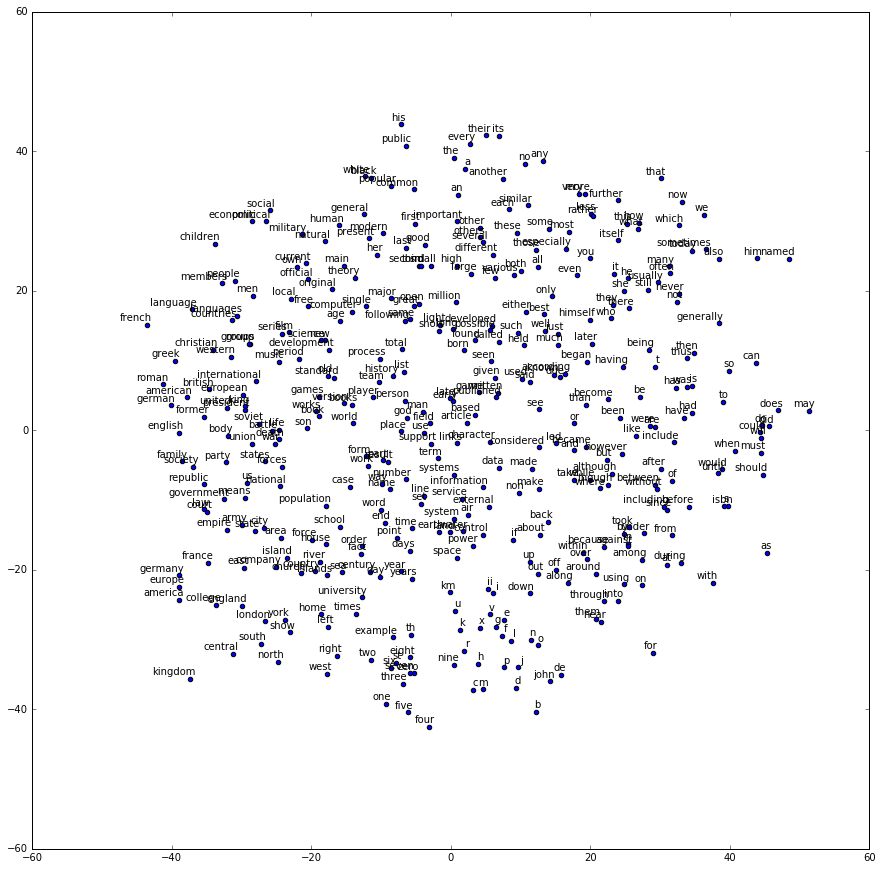

In [67]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)